In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.spatial.transform import Rotation as R 
import pickle 
import os 
import glob 
from mpl_toolkits.mplot3d import Axes3D 
import random 
import heapq

In [2]:
# functions
# function to compute distance between a line segment and point 
def dist_point_to_segment(P0, PA, PB): 
    len_sq = np.linalg.norm(PB-PA)**2  
    if len_sq == 0.0: 
        return np.linalg.norm(P0-PA) 
    d = np.linalg.norm(np.linalg.cross((P0-PA),(P0-PB))) / np.linalg.norm(PB-PA) # see: https://mathworld.wolfram.com/Point-LineDistance3-Dimensional.html 
    dot = np.dot((P0-PA),(PB-PA)) 
    p = dot / len_sq # see: https://stackoverflow.com/questions/849211/shortest-distance-between-a-point-and-a-line-segment
    if p < 0: 
        dist = np.linalg.norm(P0-PA)  
    elif p > 1: 
        dist = np.linalg.norm(P0-PB) 
    else: 
        dist = d  
    return dist 

# function to classify hole point into hole geometry element 
def classify_hole_point(point, hole_parameters, tol=0.1, flag_single_class=True): 
    x = point[0]
    y = point[1] 
    z = point[2] 
    hole_geom_class = [] 

    RR = hole_parameters['R'] 
    a = hole_parameters['a'] 
    b = hole_parameters['b']  
    d = hole_parameters['d']  
    z_h_top = -(d/2 - np.sqrt((d/2)**2 - (a/2)**2))
    z_h_bot = -d + (d/2 - np.sqrt((d/2)**2 - (a/2)**2));  

    # vertices 
    HV1 = np.array([-a/2, -np.sqrt(RR**2 - (a/2)**2), z_h_top])
    HV2 = np.array([+a/2, -np.sqrt(RR**2 - (a/2)**2), z_h_top])
    HV3 = np.array([-a/2, -(b+np.sqrt(RR**2 - (a/2)**2)), z_h_top]) 
    HV4 = np.array([+a/2, -(b+np.sqrt(RR**2 - (a/2)**2)), z_h_top]) 
    HV1_bot = np.array([-a/2, -np.sqrt(RR**2 - (a/2)**2), z_h_bot])
    HV2_bot = np.array([+a/2, -np.sqrt(RR**2 - (a/2)**2), z_h_bot])
    HV3_bot = np.array([-a/2, -(b+np.sqrt(RR**2 - (a/2)**2)), z_h_bot]) 
    HV4_bot = np.array([+a/2, -(b+np.sqrt(RR**2 - (a/2)**2)), z_h_bot]) 

    vertices = [HV1, HV2, HV3, HV4] 
    vertices_class = ['HV1','HV2','HV3','HV4'] 
    for i, vertex in enumerate(vertices): 
        dist = np.linalg.norm(point - vertex) 
        if dist < 10*tol: 
            hole_geom_class.append(vertices_class[i]) 
            if flag_single_class: 
                return vertices_class[i] 

    # curved edges 
    hole_theta_arc = np.pi - np.arcsin((a/2)/RR) 
    theta = np.arctan2(-x, y) 
    rp = np.sqrt(x**2 + y**2) 

    if x < (d/2):  
        z_curved_edge_theoretical = -(d/2) + np.sqrt((d/2)**2 - x**2) 
        if theta > 0 and theta <= hole_theta_arc and np.abs(rp - RR) < tol and np.abs(z - z_curved_edge_theoretical) < tol:  
            hole_geom_class.append('HE1')
        elif theta < 0 and theta >= -hole_theta_arc and np.abs(rp - RR) < tol and np.abs(z - z_curved_edge_theoretical) < tol:
            hole_geom_class.append('HE2') 
            
    HE3 = [HV1, HV1_bot]
    HE4 = [HV2, HV2_bot]
    HE5 = [HV3, HV3_bot]
    HE6 = [HV4, HV4_bot]

    # check straight edges 
    straight_edges = [HE3, HE4, HE5, HE6]
    straight_edges_class = ['HE3', 'HE4', 'HE5', 'HE6']  
    for i, straight_edge in enumerate(straight_edges): 
        dist = dist_point_to_segment(point, straight_edge[0], straight_edge[1])  
        if dist < tol: 
            hole_geom_class.append(straight_edges_class[i]) 
            if flag_single_class: 
                return straight_edges_class[i] 

    # curved faces 
    z_curved_edge_theoretical = -(d/2) + np.sqrt((d/2)**2 - x**2) 
    if theta > 0 and theta <= hole_theta_arc and np.abs(rp - RR) < tol and z < z_curved_edge_theoretical and z > -d-z_curved_edge_theoretical:  
        hole_geom_class.append('HF1')
        if flag_single_class: 
            return 'HF1'
    elif theta < 0 and theta >= -hole_theta_arc and np.abs(rp - RR) < tol and z < z_curved_edge_theoretical and z > -d-z_curved_edge_theoretical:
        hole_geom_class.append('HF2')
        if flag_single_class: 
            return 'HF2' 

    return hole_geom_class 

# function to classify peg point into peg geometry element 
def classify_peg_point(point, peg_parameters, tol=0.1, flag_single_class=True):

    x = point[0]
    y = point[1] 
    z = point[2] 
    peg_geom_class = []  

    r = peg_parameters['r'] 
    e = peg_parameters['e'] 
    lp = peg_parameters['lp']  
    hp = peg_parameters['hp']  
    
    # z_h_top = -(d/2 - np.sqrt((d/2)**2 - (a/2)**2))

    # z_h_bot = -d + (d/2 - np.sqrt((d/2)**2 - (a/2)**2));  

    # define vertices 
    PV1 = np.array([-e, -np.sqrt(r**2 - e**2),  0])
    PV2 = np.array([+e, -np.sqrt(r**2 - e**2), 0])
    PV3 = np.array([-e, -lp, 0]) 
    PV4 = np.array([+e, -lp, 0]) 

    # straight edges 
    PE3 = [PV1, PV3]
    PE4 = [PV2, PV4] 
    
    # check straight edges 
    straight_edges = [PE3, PE4] 
    straight_edges_class = ['PE3', 'PE4']   
    for i, straight_edge in enumerate(straight_edges): 
        dist = dist_point_to_segment(point, straight_edge[0], straight_edge[1])  
        if dist < tol: 
            peg_geom_class.append(straight_edges_class[i]) 
            if flag_single_class: 
                return straight_edges_class[i] 
    
    # curved edges 
    peg_theta_arc = np.pi - np.arcsin(e/r) 
    theta = np.arctan2(-x, y) 
    rp = np.sqrt(x**2 + y**2) 
  
    if theta > 0 and theta <= peg_theta_arc and np.abs(rp - r) < tol and np.abs(z-0)<tol:  
        peg_geom_class.append('PE1')
        if flag_single_class: 
            return 'PE1'    
    elif theta < 0 and theta >= -peg_theta_arc and np.abs(rp - r) < tol and np.abs(z-0)<tol: 
        peg_geom_class.append('PE2') 
        if flag_single_class: 
            return 'PE2' 

    # curved faces 
    if theta > 0 and theta <= peg_theta_arc and np.abs(rp - r) < tol and z > 0 and z < hp + tol:  
        peg_geom_class.append('PF1')
        if flag_single_class: 
            return 'PF1'    
    elif theta < 0 and theta >= -peg_theta_arc and np.abs(rp - r) < tol and z > 0 and z < hp + tol:
        peg_geom_class.append('PF2') 
        if flag_single_class: 
            return 'PF2' 

    # flat faces 
    if y > -lp-tol and y < -np.sqrt(r**2 - e**2)+tol and z > -tol and z < hp+tol:  
        if np.abs(x+e)<tol: 
            peg_geom_class.append('PF3') 
            if flag_single_class: 
                return 'PF3'
        elif np.abs(x-e)<tol: 
            peg_geom_class.append('PF4') 
            if flag_single_class: 
                return 'PF4'

    # if not peg_geom_class: 
    #     peg_geom_class = 'None' 
    return peg_geom_class 

In [3]:
## go through all the pkl files and identify contact state 

# define geometry parameters 
hole_parameters = {
    'R': 3.05, 
    'a': 4.5, 
    'b': 7.0 - np.sqrt(3.05**2 - (4.5/2)**2), 
    'd': 10, 
} 
peg_parameters = {
    'r': 3.0, 
    'e': 2.2, 
    'lp': 29, 
    'hp': 30, 
} 
hole_classes = ['HF1','HF2','HE1','HE2','HE3','HE4','HE5','HE6','HV1','HV2','HV3','HV4'] 
peg_classes = ['PF1','PF2','PF3','PF4','PE1','PE2','PE3','PE4'] 
peg_hole_classes = [] 
for hole_class in hole_classes: 
    for peg_class in peg_classes: 
        peg_hole_classes.append(f'{hole_class}-{peg_class}') 

# read in pkl file 
dir_pkl = "/media/rp/Elements/abhay_ws/mujoco_contact_graph_generation/results/data_v5/pkl"

# list all pkl files in the directory 
pkl_files = sorted(glob.glob(os.path.join(dir_pkl, "*.pkl")), key=os.path.getmtime)

dir_save = dir_pkl.removesuffix("pkl") + "processed_data"
if not os.path.exists(dir_save): 
    os.makedirs(dir_save)

# list of all contact state history 
N_timesteps = 500 
N_trials = 10000 # len(pkl_files) 
pkl_files = pkl_files[:N_trials] 
contact_matrix_hist_all = np.zeros((len(hole_classes), len(peg_classes), N_timesteps, N_trials), dtype=bool) 
N_single_contact = len(hole_classes)*len(peg_classes) 
mujoco_state_labels = ['time','X','Y','Z','QX','QY','QZ','QW','X_dot','Y_dot','Z_dot','A_dot','B_dot','C_dot','FX','FY','FZ','TX','TY','TZ','x','y','z','qx','qy','qz','qw'] 
N_state_mujoco = len(mujoco_state_labels) 
N_states = N_state_mujoco + N_single_contact
state_hist_all = np.zeros((N_states, N_timesteps, N_trials)) 
contact_state_hist_all = np.zeros((N_timesteps, N_trials, N_single_contact), dtype=bool) 
quasi_static_hist_all = np.zeros((N_timesteps, N_trials), dtype=bool) 
quasi_static_thresh = 0.001 # 1 mm/s 
flag_quasi_static_constraint = True 

for i, pkl_file in enumerate(pkl_files): 
    
    # Read the pickle file
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)

    # unpack data 
    state_hist = data['state_hist'] 
    # contact_num = data['contact_num'] 
    # contact_geom1 = data['contact_geom1'] 
    # contact_geom2 = data['contact_geom2'] 
    # contact_dist = data['contact_dist'] 
    contact_pos = data['contact_pos'] 
    # contact_frame = data['contact_frame'] 
    # ctrl_hist = data['ctrl_hist'] 
    sensor_hist = data['sensor_hist']   

    # initialize data structure for contact state history 
    contact_state_hist = np.zeros((len(hole_classes), len(peg_classes), len(state_hist)), dtype=bool)

    for j, contact_pos_j in enumerate(contact_pos): # iterate through each time step 

        if flag_quasi_static_constraint: 
            # check if the contact is quasi-static 
            if np.max(np.abs(state_hist[j,8:11])) < quasi_static_thresh: 
                quasi_static_hist_all[j,i] = True 
            else:  
                quasi_static_hist_all[j,i] = False 
                continue 

        if len(contact_pos_j) > 0: # if there is contact 
            peg_pos = state_hist[j, 1:4] * 1e3 # convert from m to mm 
            peg_quat = state_hist[j, 4:8] 
            peg_R = R.from_quat(peg_quat,scalar_first=True).as_matrix() 
            for k, contact_pos_hole_frame in enumerate(contact_pos_j): # iterate through each contact at current time step 
                contact_pos_hole_frame *= 1e3 # convert from m to mm 
                contact_pos_peg_frame = (peg_R.transpose() @ (contact_pos_hole_frame - peg_pos).reshape(3,1)).reshape(3)  
                point_hole_class = classify_hole_point(contact_pos_hole_frame, hole_parameters, tol=0.1, flag_single_class=True) 
                point_peg_class = classify_peg_point(contact_pos_peg_frame, peg_parameters, tol=0.1, flag_single_class=True) 

                for ii, hole_class in enumerate(hole_classes): 
                    for jj, peg_class in enumerate(peg_classes): 
                        if (hole_class in point_hole_class) and (peg_class in point_peg_class): 
                            contact_state_hist[ii,jj,j] = True 

        contact_state_hist_all[j,i] = contact_state_hist[:,:,j].flatten().astype(int) 
        state_hist_all[:N_state_mujoco,j,i] = np.hstack((state_hist[j,:], sensor_hist[j,:])) 
        state_hist_all[N_state_mujoco:,j,i] = contact_state_hist[:,:,j].flatten().astype(int) 

    # save contact state history to list 
    contact_matrix_hist_all[:,:,:,i] = contact_state_hist 

state_hist_all_flat = state_hist_all.reshape(N_states, N_timesteps*N_trials).transpose() 
df_state = pd.DataFrame(state_hist_all_flat, columns=mujoco_state_labels+peg_hole_classes)   

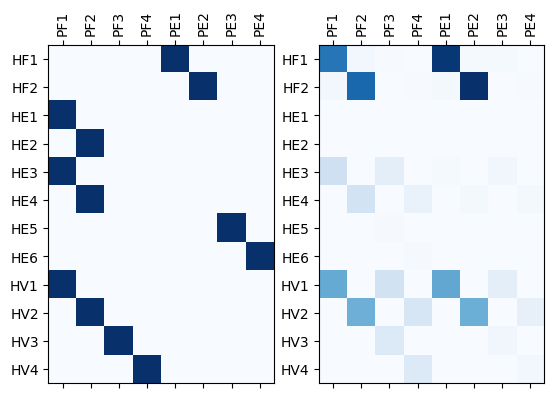

In [4]:
# plot frequencies of contact element pairs 

contact_state_freq = np.sum(np.sum(contact_matrix_hist_all, axis=3), axis=2) 

contact_state_paper = np.array([[0,0,0,0,1,0,0,0],
                                  [0,0,0,0,0,1,0,0],
                                  [1,0,0,0,0,0,0,0],
                                  [0,1,0,0,0,0,0,0],
                                  [1,0,0,0,0,0,0,0],
                                  [0,1,0,0,0,0,0,0],
                                  [0,0,0,0,0,0,1,0],
                                  [0,0,0,0,0,0,0,1],
                                  [1,0,0,0,0,0,0,0],
                                  [0,1,0,0,0,0,0,0],
                                  [0,0,1,0,0,0,0,0],
                                  [0,0,0,1,0,0,0,0]]) 

fig, axs = plt.subplots(1,2)

# label axes with peg_classes and hole_classes 
axs[0].set_xticks(np.arange(len(peg_classes)))
axs[0].set_yticks(np.arange(len(hole_classes)))

axs[0].matshow(contact_state_paper, cmap=plt.cm.Blues)
for i in range(contact_state_paper.shape[0]):
    for j in range(contact_state_paper.shape[1]):
        c = contact_state_paper[i,j] 

axs[0].set_xticks([0,1,2,3,4,5,6,7], peg_classes, rotation=90)
axs[0].set_yticks([0,1,2,3,4,5,6,7,8,9,10,11], hole_classes, rotation=0 ) 

axs[1].matshow(contact_state_freq, cmap=plt.cm.Blues)
for i in range(contact_state_freq.shape[0]):
    for j in range(contact_state_freq.shape[1]):
        c = contact_state_freq[i,j]

axs[1].set_xticks([0,1,2,3,4,5,6,7], peg_classes, rotation=90)
axs[1].set_yticks([0,1,2,3,4,5,6,7,8,9,10,11], hole_classes, rotation=0 ) 
        

1972 unique contact state types found.


Text(0, 0.5, 'Number of unique contact state types found')

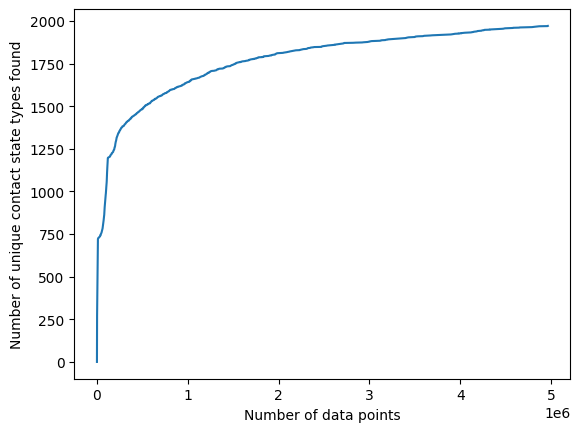

In [5]:
# identify contact state types and label each contact state in history 

# RUNTIME: 
# 1.5m for 100 trials of 500 timesteps 
# 40m for 1000 trials of 500 timesteps
# 360m for 10000 trials of 500 timesteps 

contact_types_matrix_list = [] 
contact_types_matrix_freq = [] 
contact_type_idx_discover_list = [] 
contact_state_type_hist_all = np.zeros((N_timesteps, N_trials), dtype=int) - 1 
no_contact_matrix = np.zeros((len(hole_classes), len(peg_classes)), dtype=bool) 

for i in range(N_timesteps):    
    for j in range(N_trials): 

        contact_state_ij = contact_matrix_hist_all[:,:,i,j] 

        # label contact state type 
        for k, contact_type_k in enumerate(contact_types_matrix_list): 
            if np.array_equal(contact_state_ij, contact_type_k): 
                contact_state_type_hist_all[i,j] = k # label contact state type 
                contact_types_matrix_freq[k] += 1 
                # contact_type_idx_discover_list.append(i*N_trials + j) 
                break # note: search could be optimized by reordering the list based on frequency of occurence 
        
        # if no match found, add new contact state type 
        if contact_state_type_hist_all[i,j] == -1 and not np.array_equal(contact_state_ij, no_contact_matrix): 
            contact_types_matrix_list.append(contact_state_ij) # add new contact state type to list 
            k_new = len(contact_types_matrix_list) - 1
            contact_state_type_hist_all[i,j] = k_new # new label for contact state type 
            contact_types_matrix_freq.append(1) # create new entry in frequency list and assign value of 1 
            contact_type_idx_discover_list.append(i*N_trials + j) 

        df_state.loc[i*N_trials + j, 'contact_type'] = contact_state_type_hist_all[i,j] 

N_contact_types = len(contact_types_matrix_list) 
print(f"{N_contact_types} unique contact state types found.") 

plt.figure() 
plt.plot(contact_type_idx_discover_list, np.arange(len(contact_type_idx_discover_list))) 
plt.xlabel("Number of data points") 
plt.ylabel("Number of unique contact state types found") 

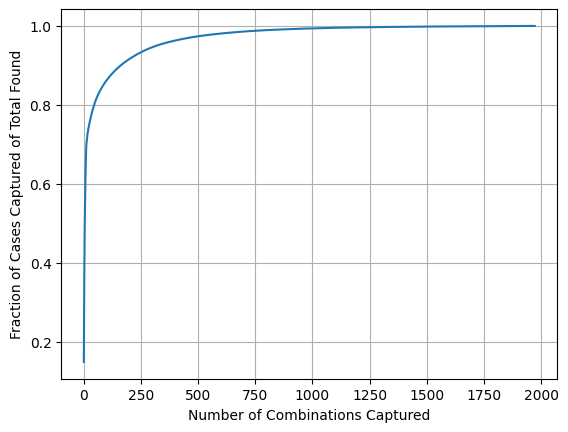

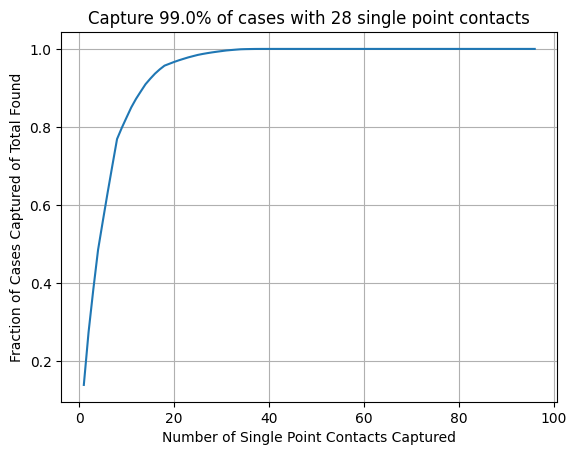

In [6]:
# plot of percent of cases captured by top N contact state types 
frac_cases_captured = np.zeros(N_contact_types)  
frac_combinations_captured = np.zeros(N_contact_types) 
for N in range(N_contact_types): 
    N_contact_types_top = N + 1 
    top_n = heapq.nlargest(N_contact_types_top, enumerate(contact_types_matrix_freq), key=lambda x: x[1])
    top_values = [value for index, value in top_n]
    top_indices_type = [index for index, value in top_n]
    frac_cases_captured[N] = np.sum(top_values) / np.sum(contact_types_matrix_freq) 

# plot of contact state type frequency  
plt.figure()
plt.plot((np.arange(N_contact_types)+1), frac_cases_captured) 
plt.xlabel('Number of Combinations Captured') 
plt.ylabel('Fraction of Cases Captured of Total Found') 
plt.grid(True)

# plot of percent of cases captured by top N contact state elements  
frac_cases_captured_single_contact = np.zeros(N_single_contact)  
frac_combinations_captured = np.zeros(N_single_contact) 
for N in range(N_single_contact): 
    N_contact_states_top = N + 1 
    top_n = heapq.nlargest(N_contact_states_top, enumerate(contact_state_freq.flatten()), key=lambda x: x[1])
    top_values = [value for index, value in top_n]
    top_indices_state = [index for index, value in top_n]
    frac_cases_captured_single_contact[N] = np.sum(top_values) / np.sum(contact_state_freq.flatten()) 

thresh_capture_single_contact = .99
N_single_contact_capture = np.argmax(frac_cases_captured_single_contact > thresh_capture_single_contact) + 1 

# plot of contact state type frequency  
plt.figure()
plt.plot((np.arange(N_single_contact)+1), frac_cases_captured_single_contact) 
plt.xlabel('Number of Single Point Contacts Captured') 
plt.ylabel('Fraction of Cases Captured of Total Found') 
plt.title(f"Capture {thresh_capture_single_contact*100}% of cases with {N_single_contact_capture} single point contacts") 
plt.grid(True)

Top N values: [43772, 40828, 23109, 22484, 15304, 13132, 11891, 9494, 8495, 6471, 5937, 4830, 1707, 1560, 1552, 1504, 1486, 1185, 1064, 1012, 977, 963, 915, 872, 865, 799, 796, 784, 777, 771, 766, 727, 717, 683, 681, 641, 637, 620, 618, 616, 587, 583, 581, 561, 550, 522, 517, 511, 506, 498, 479, 477, 476, 474, 473, 412, 410, 401, 395, 393, 384, 383, 374, 368, 353, 352, 348, 346, 336, 326, 321, 320, 319, 313, 311, 309, 306, 299, 292, 284, 281, 278, 275, 273, 272, 272, 269, 269, 265, 264, 262, 257, 254, 254, 252, 247, 240, 235, 234, 229]
Indices of top N values: [383, 507, 1215, 1214, 27, 37, 6, 7, 1220, 1216, 1225, 1223, 1255, 1281, 1304, 1284, 1901, 1247, 1551, 1397, 969, 1242, 115, 1340, 1273, 1291, 1533, 1297, 1287, 1739, 733, 1732, 1892, 1217, 1224, 1250, 43, 1237, 870, 1740, 1271, 1280, 1265, 1576, 1711, 1715, 415, 1555, 1726, 1206, 1306, 1296, 825, 1334, 1542, 1855, 1267, 298, 1209, 3, 1251, 1717, 1493, 1362, 916, 485, 304, 1324, 1320, 1221, 1240, 331, 1734, 1471, 1599, 344, 195, 

Text(0.5, 1.0, 'Top N = 100 Contact State Type Frequency \n86.18% of cases captured by 5.07% of combinations')

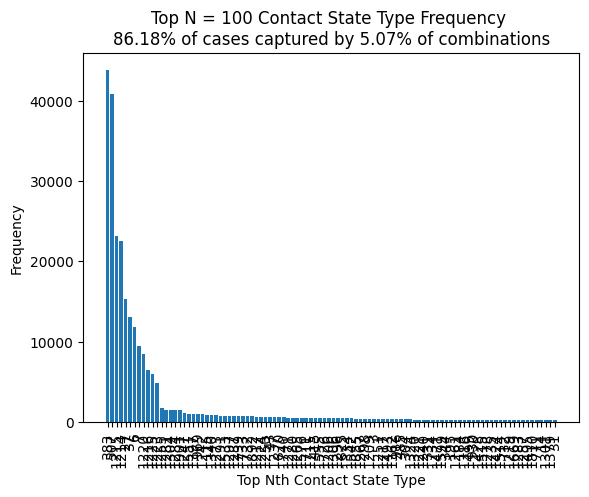

In [7]:
# find top N values and indices 

N_contact_types_top_freq = np.min([N_contact_types, 100])      
top_n = heapq.nlargest(N_contact_types_top_freq, enumerate(contact_types_matrix_freq), key=lambda x: x[1])
top_values = [value for index, value in top_n]
top_indices_type = [index for index, value in top_n] 
percent_cases_captured = np.sum(top_values) / np.sum(contact_types_matrix_freq) * 100 
percent_combinations_captured = N_contact_types_top_freq / N_contact_types * 100 



print("Top N values:", top_values)
print("Indices of top N values:", top_indices_type) 

# plot histogram of top N values 
plt.figure() 
plt.bar(np.arange(N_contact_types_top_freq), top_values) 
plt.xticks(ticks=range(N_contact_types_top_freq), labels=top_indices_type)
plt.xticks(rotation=90)  # Rotate labels by 90 degrees
plt.xlabel("Top Nth Contact State Type")  
plt.ylabel("Frequency") 
plt.title(f"Top N = {N_contact_types_top_freq} Contact State Type Frequency \n{percent_cases_captured:.2f}% of cases captured by {percent_combinations_captured:.2f}% of combinations")  

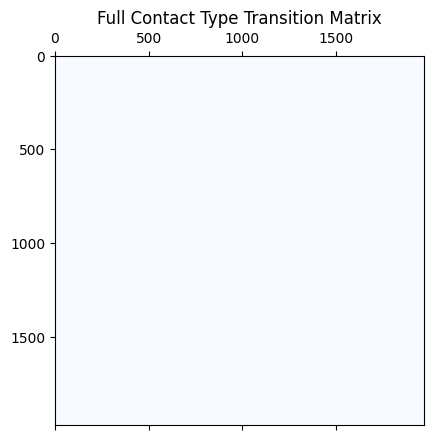

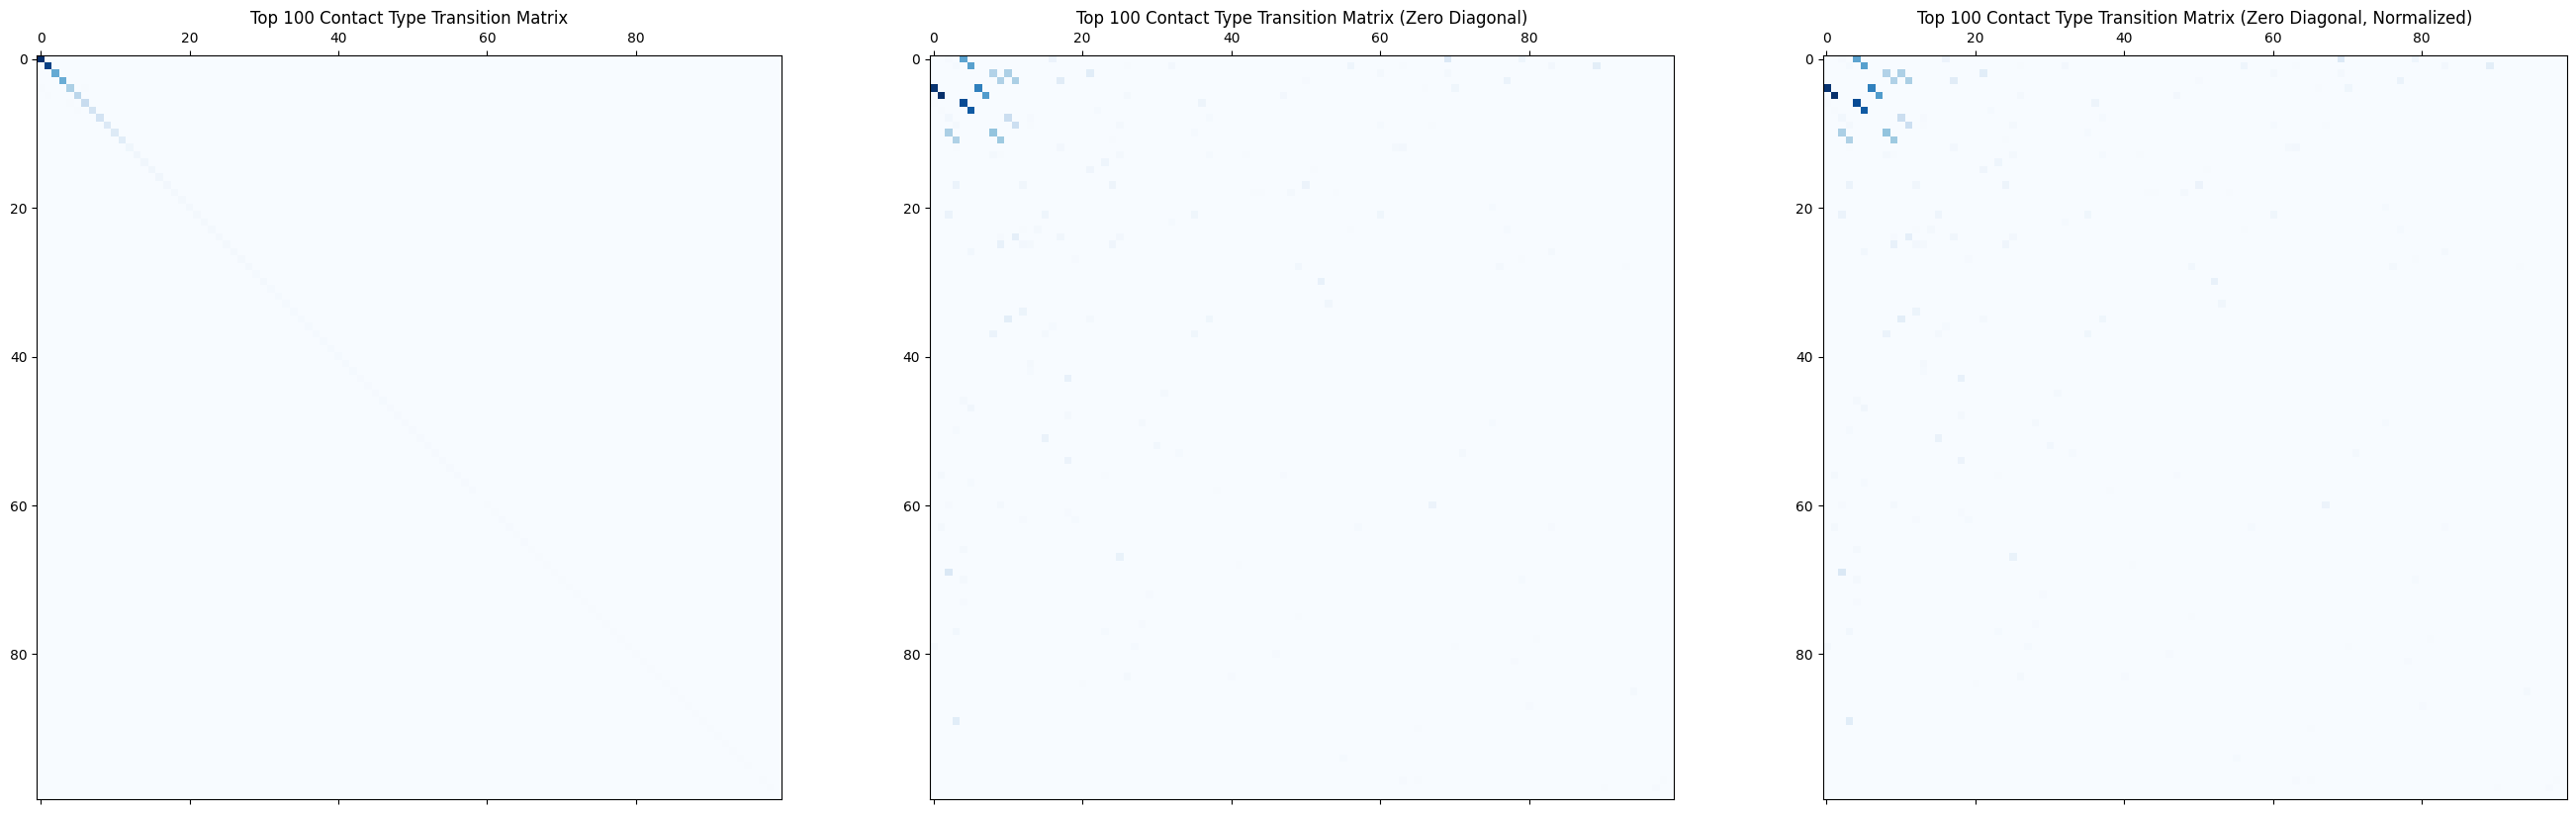

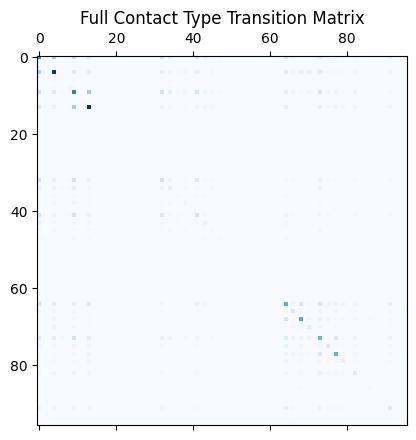

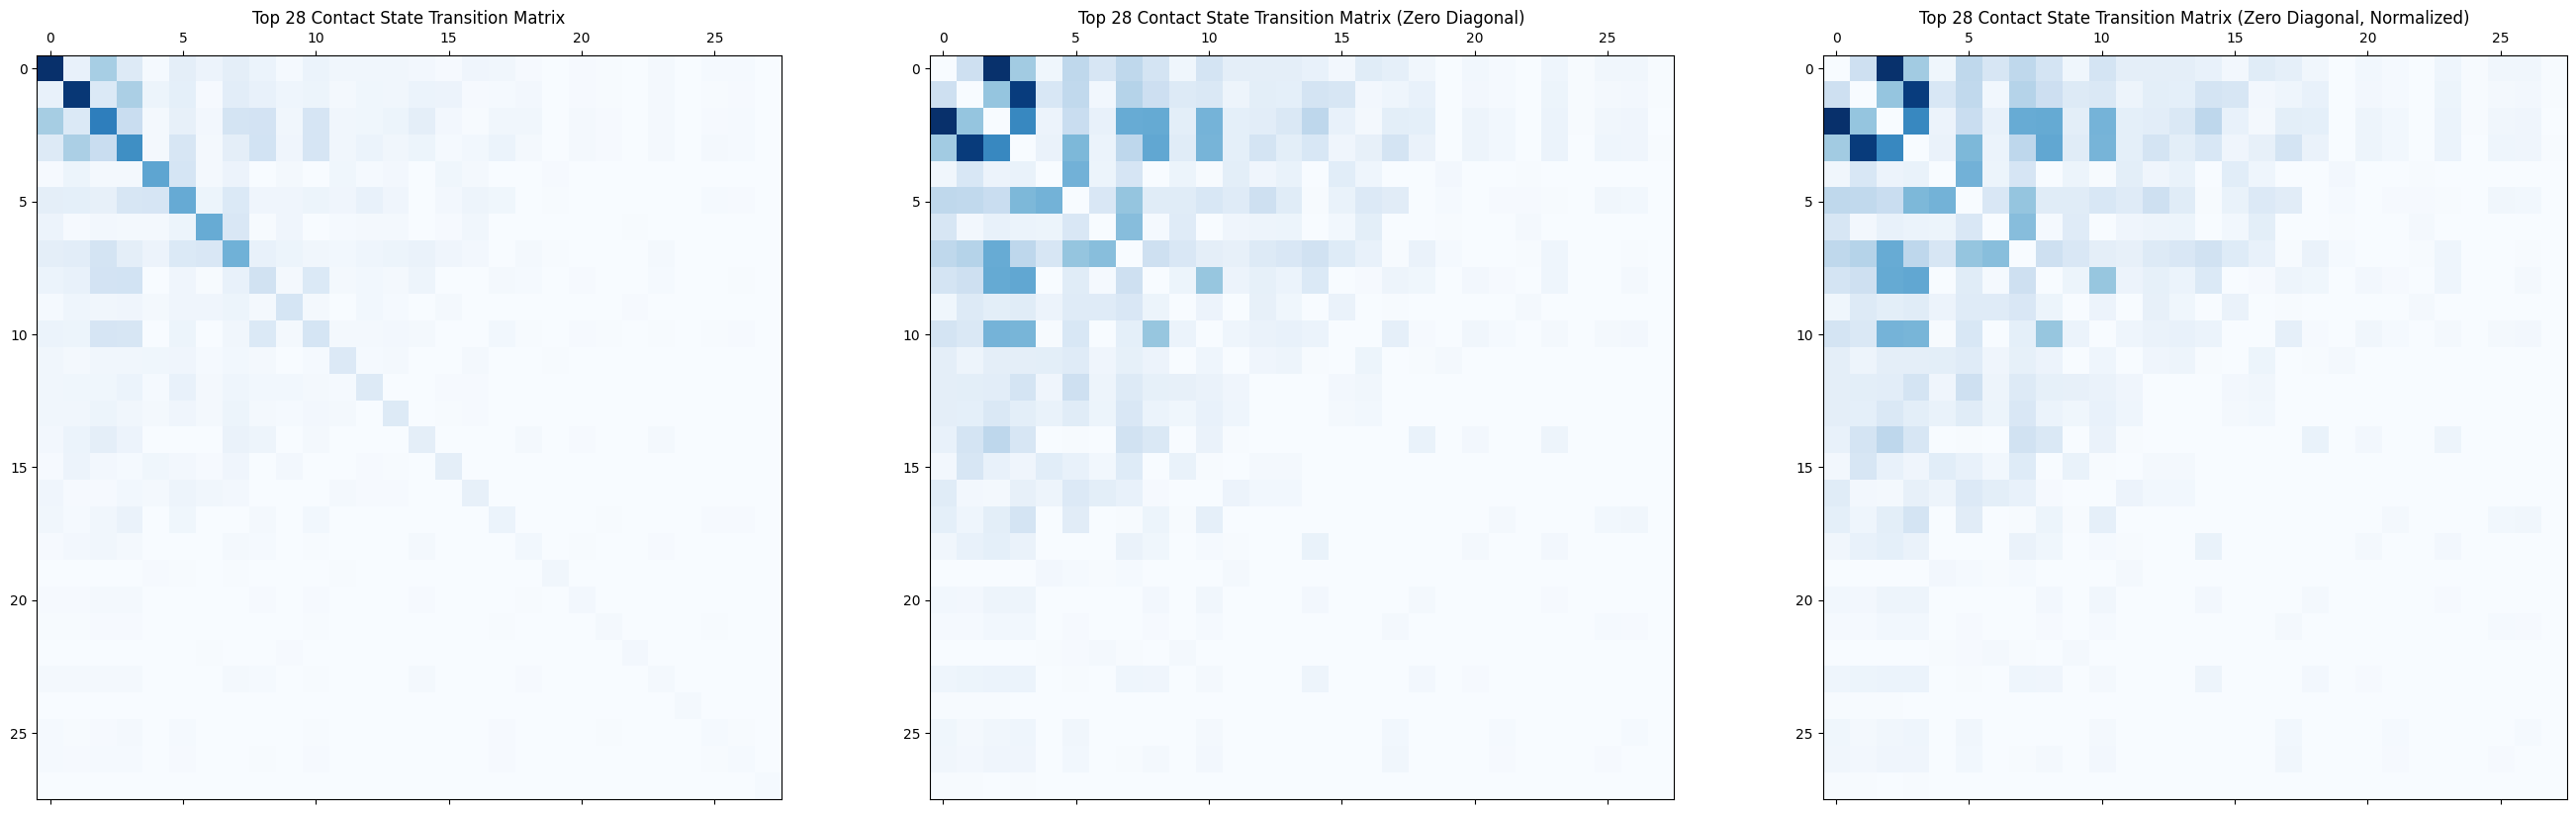

In [8]:
# identify all unique contact state type transitions and state transitions 

contact_type_transition_matrix = np.zeros((N_contact_types, N_contact_types), dtype=int) 
contact_state_transition_matrix = np.zeros((N_single_contact, N_single_contact), dtype=int) 
for i in range(N_timesteps-1): 
    for j in range(N_trials): 
        contact_state_type_i = contact_state_type_hist_all[i,j] 
        contact_state_type_ip1 = contact_state_type_hist_all[i+1,j] 
        contact_type_transition_matrix[contact_state_type_i, contact_state_type_ip1] += 1 

        contact_state_i = contact_state_hist_all[i,j] 
        contact_state_ip1 = contact_state_hist_all[i+1,j] 
        contact_state_transition_matrix += np.outer(contact_state_i, contact_state_ip1) 

## plot state type transition matrix 
# plot state type transition matrix 
fig, axs = plt.subplots()
axs.matshow(contact_type_transition_matrix, cmap=plt.cm.Blues)
axs.set_title("Full Contact Type Transition Matrix")
for i in range(contact_type_transition_matrix.shape[0]):
    for j in range(contact_type_transition_matrix.shape[1]):
        c = contact_type_transition_matrix[i,j] 

# only plot top N transitions 
contact_type_transition_matrix_top_N = np.zeros((N_contact_types_top_freq, N_contact_types_top_freq), dtype=int)   
for i, index_i in enumerate(top_indices_type): 
    for j, index_j in enumerate(top_indices_type): 
        contact_type_transition_matrix_top_N[i,j] = contact_type_transition_matrix[index_i, index_j] 

# plot state type transition matrix - top N 
fig, axs = plt.subplots(1,3,figsize=(33,10))
axs[0].matshow(contact_type_transition_matrix_top_N, cmap=plt.cm.Blues)
axs[0].set_title(f"Top {N_contact_types_top_freq} Contact Type Transition Matrix")
for i in range(contact_type_transition_matrix_top_N.shape[0]):
    for j in range(contact_type_transition_matrix_top_N.shape[1]):
        c = contact_type_transition_matrix_top_N[i,j] 

# plot state type transition matrix - zero diagonal  
contact_type_transition_matrix_top_N_no_diag = contact_type_transition_matrix_top_N.copy()
np.fill_diagonal(contact_type_transition_matrix_top_N_no_diag, 0) 

# fig, axs = plt.subplots()
axs[1].matshow(contact_type_transition_matrix_top_N_no_diag, cmap=plt.cm.Blues)
axs[1].set_title(f"Top {N_contact_types_top_freq} Contact Type Transition Matrix (Zero Diagonal)")
for i in range(contact_type_transition_matrix_top_N_no_diag.shape[0]):
    for j in range(contact_type_transition_matrix_top_N_no_diag.shape[1]):
        c = contact_type_transition_matrix_top_N_no_diag[i,j] 

# plot state type transition matrix - zero diagonal and origin frequency normalized offdiagonal values  
contact_type_transition_matrix_top_N_no_diag = contact_type_transition_matrix_top_N.copy()
np.fill_diagonal(contact_type_transition_matrix_top_N_no_diag, 0) 

# fig, axs = plt.subplots()
axs[2].matshow(contact_type_transition_matrix_top_N_no_diag, cmap=plt.cm.Blues)
axs[2].set_title(f"Top {N_contact_types_top_freq} Contact Type Transition Matrix (Zero Diagonal, Normalized)") 
for i in range(contact_type_transition_matrix_top_N_no_diag.shape[0]):
    for j in range(contact_type_transition_matrix_top_N_no_diag.shape[1]):
        c = contact_type_transition_matrix_top_N_no_diag[i,j] / top_values[j]  


## plot state transition matrix
# plot state transition matrix 
fig, axs = plt.subplots()
axs.matshow(contact_state_transition_matrix, cmap=plt.cm.Blues)
axs.set_title("Full Contact Type Transition Matrix")
for i in range(contact_state_transition_matrix.shape[0]):
    for j in range(contact_state_transition_matrix.shape[1]):
        c = contact_state_transition_matrix[i,j] 

# only plot top N transitions 
contact_state_transition_matrix_top_N = np.zeros((N_single_contact_capture, N_single_contact_capture), dtype=int)   
for i, index_i in enumerate(top_indices_state[:N_single_contact_capture]): 
    for j, index_j in enumerate(top_indices_state[:N_single_contact_capture]): 
        contact_state_transition_matrix_top_N[i,j] = contact_state_transition_matrix[index_i, index_j] 

# plot state type transition matrix - top N 
fig, axs = plt.subplots(1,3,figsize=(33,10))
axs[0].matshow(contact_state_transition_matrix_top_N, cmap=plt.cm.Blues)
axs[0].set_title(f"Top {N_single_contact_capture} Contact State Transition Matrix")
for i in range(contact_state_transition_matrix_top_N.shape[0]):
    for j in range(contact_state_transition_matrix_top_N.shape[1]):
        c = contact_state_transition_matrix_top_N[i,j] 

# plot state type transition matrix - zero diagonal  
contact_type_transition_matrix_top_N_no_diag = contact_state_transition_matrix_top_N.copy()
np.fill_diagonal(contact_type_transition_matrix_top_N_no_diag, 0) 

# fig, axs = plt.subplots()
axs[1].matshow(contact_type_transition_matrix_top_N_no_diag, cmap=plt.cm.Blues)
axs[1].set_title(f"Top {N_single_contact_capture} Contact State Transition Matrix (Zero Diagonal)")
for i in range(contact_type_transition_matrix_top_N_no_diag.shape[0]):
    for j in range(contact_type_transition_matrix_top_N_no_diag.shape[1]):
        c = contact_type_transition_matrix_top_N_no_diag[i,j] 

# plot state type transition matrix - zero diagonal and origin frequency normalized offdiagonal values  
contact_type_transition_matrix_top_N_no_diag = contact_state_transition_matrix_top_N.copy()
np.fill_diagonal(contact_type_transition_matrix_top_N_no_diag, 0) 

# fig, axs = plt.subplots()
axs[2].matshow(contact_type_transition_matrix_top_N_no_diag, cmap=plt.cm.Blues)
axs[2].set_title(f"Top {N_single_contact_capture} Contact State Transition Matrix (Zero Diagonal, Normalized)") 
for i in range(contact_type_transition_matrix_top_N_no_diag.shape[0]):
    for j in range(contact_type_transition_matrix_top_N_no_diag.shape[1]):
        c = contact_type_transition_matrix_top_N_no_diag[i,j] / top_values[j]  


In [9]:
# gather all wrench values for each contact state type in a pandas dataframe 

# list all pkl files in the directory 
pkl_files = sorted(glob.glob(os.path.join(dir_pkl, "*.pkl")), key=os.path.getmtime)

# list of all contact state history 
N_timesteps = 500 
# N_trials = 100 # len(pkl_files) 
pkl_files = pkl_files[:N_trials] 

# initialize data structure for wrench values 
wrench_hist_all = np.zeros((6, N_timesteps, N_trials)) 
wrench_and_contact_matrix_hist_all = np.zeros((N_timesteps*N_trials, 6+1))  
time_pose_wrench_contact_matrix_hist_all = np.zeros((N_timesteps*N_trials, 1+7+6+6+1)) 

for i, pkl_file in enumerate(pkl_files): 
    state_hist = data['state_hist'] 
    sensor_hist = data['sensor_hist'] 
    wrench_hist_all[:,:,i] = sensor_hist[:,:6].transpose() 

    for j in range(N_timesteps): 
        sensor_hist_ij = sensor_hist[j,:6] 
        state_hist_ij = state_hist[j,:] 
        contact_state_type_ij = contact_state_type_hist_all[j,i] 
        wrench_and_contact_matrix_hist_all[i*N_timesteps + j,:] = np.concatenate((sensor_hist_ij, np.array([contact_state_type_ij]))).transpose()  
        time_pose_wrench_contact_matrix_hist_all[i*N_timesteps + j,:] = np.concatenate((state_hist_ij, sensor_hist_ij, np.array([contact_state_type_ij]))).transpose() 

# save data as csv 
df_wrench_contact_type = pd.DataFrame(wrench_and_contact_matrix_hist_all, columns=['FX','FY','FZ','TX','TY','TZ','contact_type'])  
df_wrench_contact_type.to_csv(os.path.join(dir_save, "wrench_and_contact_matrix_hist_all.csv"), index=False) 

df_pose_wrench_contact_type = pd.DataFrame(time_pose_wrench_contact_matrix_hist_all, columns=['T','X','Y','Z','QX','QY','QZ','QW','VX','VY','VZ','VA','VB','VC','FX','FY','FZ','TX','TY','TZ','contact_type'])
df_pose_wrench_contact_type.to_csv(os.path.join(dir_save, "pose_wrench_and_contact_matrix_hist_all.csv"), index=False) 

In [10]:
num_filtered = len(df_pose_wrench_contact_type[df_pose_wrench_contact_type['contact_type'] != -1]) 
frac_filtered = num_filtered / len(df_pose_wrench_contact_type)
print(num_filtered)
print(frac_filtered) 

294354
0.0588708


In [11]:
# save data 

dir_save = dir_pkl.removesuffix("pkl") + "processed_data_10k" 
if not os.path.exists(dir_save): 
    os.makedirs(dir_save) 
 
# save the following variables as pkl files 
with open(os.path.join(dir_save, "contact_matrix_hist_all.pkl"), 'wb') as f: 
    pickle.dump(contact_matrix_hist_all, f)

with open(os.path.join(dir_save, "contact_types_matrix_list.pkl"), 'wb') as f:
    pickle.dump(contact_types_matrix_list, f)

with open(os.path.join(dir_save, "contact_types_matrix_freq.pkl"), 'wb') as f:
    pickle.dump(contact_types_matrix_freq, f)

with open(os.path.join(dir_save, "contact_type_idx_discover_list.pkl"), 'wb') as f:
    pickle.dump(contact_type_idx_discover_list, f) 

with open(os.path.join(dir_save, "contact_state_type_hist_all.pkl"), 'wb') as f:
    pickle.dump(contact_state_type_hist_all, f) 

df_state.to_csv(os.path.join(dir_save, "state_hist_all.csv"), index=False) 